## Analyze A/B Test Results
### by Ibrahim Olayiwola

## Table of contents.

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IV - Conclusions](#conclusions)


<a id='intro'></a>
### Introduction
>A/B tests are very commonly performed by to test weather a changeversion of a webpage brings about more conversion in users.
For this project, I will be working to understand the results of an A/B test run by an e-commerce website. The goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

>The A/B test has been carried out and what remains is for me to analyze it. The reason I'm doing this analysis is to help an e-commerce company know if they should implement a new page, keep the old page, or perhaps run the experiment longer to make a decision. The A/B test results is save in a csv file name ab_data.


<a id='probability'></a>
### Part I - Probability

>In this part, we'd calculate some probabilities, but to get started, we'd import our libraries and do some preliminary cleaning of the data. We'd also copy our data to use for the analysis to preserve our original dataset.

In [1]:
import pandas as pd
import numpy as np
import random 
import matplotlib.pyplot as plt

# Setting seed so as to get uniform answer when another analyst carries out this test.
random.seed(42)

>Now, the data will be read in and stored in a dataframe.

In [2]:
df = pd.read_csv('ab_data.csv')

# Checking the first 5 rows of the dataframe.
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


>From the above rows, we can see that;
- There are 5 columns in the dataset.
- The users were divided into two groups, the control group which were shown the old landing page and the treatment group which were shown the new landing page.
- There is also a column that shows if a user was converted or not based on the page they were shown.

Next, I would explore the dataset to know more about it.

In [3]:
# Number of rows in the dataset
df.shape[0]

294478

>There are two hundred and ninety-four thousand, four hundred and seventy-eight (294,478) rows in the dataset.

>Next is to check the number of unique users and other unique details about the dataset.

In [4]:
# Unique details
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

> So, from the output above we can say that
- Out of 294478 users, 290584 are unique meaning 3894 are duplicate of some users.
- The users were divided into two main groups, the control group and the treatment group.
- There are two landing pages, the old page and the new page.
- Users were either converted or not.

Now, we'd check the proportion of users converted.

In [5]:
# Proportion of users converted
df.converted.mean()

0.11965919355605512

> Approximately 12% of users were converted. 

> From basic knowledge and from the data thats been previewed, we know that the treatment group is meant to match the new landing page and the control group is meant to match the old landing page. However, there might be some errors so we would check if some users in a group doesn't match the page they were supposed to match.

In [6]:
# The number of times the new_page and treatment don't match.
df.query('(group != "treatment" and landing_page == "new_page") or (group == "treatment" and landing_page != "new_page")').user_id.count()

3893

> The number of time the pages and the landing page doesn't match is 3893.

>Now, we would check for missing values in the dataset.

In [7]:
# Checking for missing values.
df.isna().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

> From the above, there are no missing values in the dataset, and since we're not sure about the 3893 pages and group that does not match, we would drop the rows which the values does not match.

In [8]:
# Dropping rows in which the treatment does not match the landing page and save in df2.
df_c = df.query('group == "control" and landing_page == "old_page"')
df_t = df.query('group == "treatment" and landing_page == "new_page"')
df2 = df_c.append(df_t)
df2.shape[0]

290585

>After dropping, the number of rows decreased to 290585. Next, we'd double check for values that don't match and check for duplicate values.

In [9]:
# Double checking for pages and group that doesn't match.
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
# Check for duplicate rows
# Checking for duplicates user_id
df2[df2.duplicated(['user_id'])]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


>There is a duplicate row of user_id 773192. Let's check for more information on the duplicate.

In [11]:
df2.query('user_id == "773192"')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The duplicated row is 1899 and it has almost same information except for the timestamp. One row should be removed.

In [12]:
# Dropping row 1899
df2 = df2.drop([1899])

In [13]:
# Confirming the row has been drop
print(df2.info())
df2[df2.duplicated(['user_id'])]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       290584 non-null  int64 
 1   timestamp     290584 non-null  object
 2   group         290584 non-null  object
 3   landing_page  290584 non-null  object
 4   converted     290584 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 13.3+ MB
None


,user_id,timestamp,group,landing_page,converted


>From the above cell, we can see that there are 290584 rows and that there are no duplicated user_id.

>Alright, now we're ready to calculate the probabilities. We're going to check for the probability of
- A user converting regardless of the page they recieved.
- A user converting when he/she is shown the old landing page(i.e In the control group).
- A user converting when he/she is shown the new landing page (ie In the treatment group).
- A user being shown the new landing page and the old landing page.

**Probability of a user converting regardless of page shown.**

In [14]:
# Probability of conversion
prob_conv = df2.converted.mean()
prob_conv

0.11959708724499628

>The probability of a user converting is approximately **12%**

>Our next calculation is the probability of conversion when in the control group, ie he/she is shown the old landing page.

**Probability of a user converting when in control group**

In [15]:
control_prob_conv = df2.query('group == "control"')['converted'].mean()
control_prob_conv

0.1203863045004612

> From the immediate cell above, we got that the probability of a user being converted when in the control group, shown the old landing page, is also approximately **12%**. Based on this and the probability of the overall conversion being 12%, it is safe to assume that the probability of a user converting when in the treatment group is also approximately 12%. However let's check our assumptions.

**Probability of a user converting when in treatment group**

In [16]:
treat_prob_conv = df2.query('group == "treatment"')['converted'].mean()
treat_prob_conv

0.11880806551510564

> We got our assumption right in that the probability of a user converting while in the treatment group is approximately **12%**. However, before we can claim that a user will convert regardless of the group is 12%, we need to know the probability of a user being placed in the control group and the probability of being placed in the treatment group.

**Probability of a user being placed in the control group**

In [17]:
prob_cont_grp = df2.query('group == "control"')['group'].count()/df2.shape[0]
prob_cont_grp

0.4999380557773312

In [18]:
prob_treat_grp = 1 - prob_cont_grp
prob_treat_grp

0.5000619442226688

>The probability of being placed in one of the groups in approximately 0.5 which is fair and not biased. Therefore we can say that there is no significant change in the conversion rate if the new landing page is adopted. 

In the next part, we'd run a hypothesis test with a type 1 error rate of 5%.

<a id='ab_test'></a>
### Part II - A/B Test

> It should be noted that due to the time stamp associated with each event, a hypothesis test could technically be ran continuously as each observation was observed. However, then the hard question is do we stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time? How long do we run to render a decision that neither page is better than another?

>These questions are the difficult parts associated with A/B tests in general.

> For now, let us consider that we need to make the decision based on all the data provided. We want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. In doing this, we need to state our null and alternative hypothesis. We can state our hypothesis in terms of words or in terms of  $p_{old}$  and $p_{new}$, which are the converted rates for the old and new pages respectively.

$$H_0: P_{new} - P_{old} \leq 0$$
$$H_1: P_{new} - P_{old} > 0$$


Let's assume that under the null hypothesis,  $p_{new}$ and $p_{old}$  both have "true" success rates equal to the converted success rate regardless of page - that is  $p_{new}$ and $p_{old}$ are equal. Furthermore, we assume they are equal to the converted rate in ab_data.csv regardless of the page, we would use a sample size for each page equal to the one in **ab_data.csv**. 

Let's perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null.

In [19]:
# To get started we'll view a sample of the dataset
df2.sample(7)

,user_id,timestamp,group,landing_page,converted
71308,801063,2017-01-18 15:25:43.428394,treatment,new_page,0
208732,945789,2017-01-08 04:31:27.705624,treatment,new_page,0
227212,899456,2017-01-14 19:20:29.867608,control,old_page,0
260851,808766,2017-01-18 20:00:58.863793,control,old_page,0
83436,789699,2017-01-09 06:23:50.060093,control,old_page,0
59472,766709,2017-01-23 01:44:45.267980,control,old_page,0
156768,704879,2017-01-22 19:46:15.114301,control,old_page,1


Now that we've viewed a sample of the data let's calculate the conversion rate for $p_{new}$ under the null.

In [20]:
# Coversion rate for new page under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The result above shows that the conversion rate for the new page is approximately 12%. 

And as we have done for $P_{new}$, we would also calculate the conversion rate for the old page $P_{old}$ under the null.

In [21]:
# Conversion rate for the old page under the null.
p_old = df2['converted'].mean()
p_old

0.11959708724499628

The conversion rate for the old page under the null is same, 11.96%, as that of the new page under the floor. It should be noted that under the null, the rate of conversion for the new page and old page is probability that a page is converted.

Next, we check for the number of individuals in both groups, that is the individuals shown the new page($n_{new}$) and those shown the old page($n_{old}$).

In [22]:
# Number of individuals shown the new page
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

In [23]:
# Number of individuals shown the old page
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

From the above two cells, we get that **145,310** and **145,274** people were the new page ond old page respectively.
We can see that both groups have approximately a hundred and forty-five participants each.

The next step we'd do is to simulate $n_{new}$ (number of participants) transactions with a conversion rate of $P_{new}$ under the null and store these $n_{new}$  1's and 0's in **new_page_converted**. We'd also do the same for the old page.

In [24]:
# Simulating n transactions with a conversion rate of p.
new_page_converted = np.random.choice(2, size=n_new, p=[p_new, 1-p_new])

In [25]:
# Simulating n_old transactions with a conversion rate of p_old
old_page_converted = np.random.choice(2, size=n_old, p=[p_old, 1-p_old])

Now, we'd check for the difference of $p_{new}$ and $p_{old}$

In [26]:
p_new - p_old

0.0

Let's create 10,000  $p_{new}$  -  $p_{old}$  values using the same simulation process we used above and store all 10,000 values in a NumPy array called p_diffs.

In [27]:
p_diffs = []
new_convert = np.random.binomial(n_new,p_new,10000)/n_new
old_convert = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs = new_convert - old_convert
p_diffs

array([ 0.00019055,  0.00044519, -0.00029788, ..., -0.00136492,
       -0.00039456,  0.00120227])

Now that we've used the simulation process and stored the difference in an array, let's plot a histogram of the p_diffs. Does this plot look like what we expected?

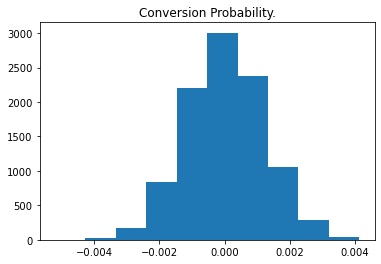

In [28]:
plt.hist(p_diffs);
plt.title('Conversion Probability.');

The next 3 steps or so will provide us with the p-value of the test. **The p-value is the evidence we use to either fail to reject to reject the null hypothesis or reject our null hypothesis.**

The p-value is the proportion of the p_diffs that are greater than the actual difference observed in **ab_data.csv** and to do that we need to find the observed difference in ab_data.csv.

In [29]:
# Observed difference in ab_data.csv
obs_diff = treat_prob_conv - control_prob_conv
obs_diff

-0.0015782389853555567

The observed difference is -0.001578.

The next step is to find the p-value.

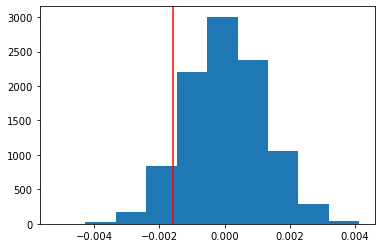

In [30]:
# Plotting the observed difference on the histogram
plt.hist(p_diffs);
plt.axvline(obs_diff, color='red');

In [31]:
# P-value
(p_diffs > obs_diff).mean()

0.9122

**The p-value is 0.9044. Since our p-value is greater than our type 1 error rate of 0.05 (5%), we fail to rejejct the null hypothesis which means we should not go with the new page and stick with the old page instead.**

We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance

In [32]:
import statsmodels.api as sm

convert_old = df2.query(" landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query(" landing_page == 'new_page' and converted == 1").shape[0]
n_old = len(df2.query('landing_page == "old_page"'))
n_new = len(df2.query('landing_page == "new_page"'))

After initializing the variables, we would use the *proportion_ztest* to compute the p-value and the z-score.

In [33]:
from statsmodels.stats.proportion import proportions_ztest

count = np.array([convert_old, convert_new])
nobs = np.array([n_old, n_new])

zstat, pval = proportions_ztest(count, nobs, alternative='smaller') # alternative=Larger cos alt hypothesis p_new > p_old
zstat, pval

(1.3109241984234394, 0.9050583127590245)

**The z-score is 1.3109 and the p-value is 0.9051. The p-value agrees with the results we obtained above.**

**The z-score is the value how many standard deviation our values are above or below the mean. A positive z-score means our values are above the mean and a negative z-score says our many standard deviation our data values are below the mean. A z-score of 0 means the values is same with the mean.**

**The z-score obtained shows that our data values are 1.3109 standard deviations above the mean.**

<a id='regression'></a>
### Part III - A Regression Approach.

In this we will try to achieve the result we achieved in the A/B test in Part II above by performing regression.

It should also be noted that **Logistic regression** will be performed because we are predicting only two possible outcomes. The goal is to use statsmodels to fit the logistic regression to see if there is a significant difference in conversion based on which page a customer receives.

However, before we start, we need to create a new column for the intercept in df2. We'd also create a dummy variable column for which page each user received.

As stated above, we'd add intercept column, as well as an ab_page column, which is 1 when an individual receives the treatment and 0 if control. We'd also get dummy  variables for the group.

In [34]:
# Adding an intercept column and a dummy variable
import statsmodels.api as sm 

df2['intercept'] = 1 # Create Intercept
df2[['ab_page', 'control']] = pd.get_dummies(df2['group']) # Get dummy variables for group

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,control
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,0
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,0


We can see the intercept and dummy column. However, we'd drop the control column as when the ab_page reads zero it means the control is one. It's only a column that is needed really.

In [35]:
# Dropping a column as only one is really needed
df2 = df2.drop(['control'], axis=1)
df2.sample(5)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
221023,785479,2017-01-05 14:44:43.525105,treatment,new_page,0,1,0
23214,770733,2017-01-07 12:50:00.649830,control,old_page,0,1,1
123064,796543,2017-01-03 06:51:58.038459,treatment,new_page,0,1,0
253585,771446,2017-01-14 00:02:11.328878,treatment,new_page,0,1,0
200992,673303,2017-01-14 19:01:09.566504,control,old_page,0,1,1


Looking at the sample above, we can see that when shown the new landing page, the ab_page reads 0(zero) which can make us confirm that the control column would have read 1(one). The opposite is the case when shown the old landing page which helps us in the argument that the control column was not needed.

Going forward, we'd use **statsmodels** to instantiate our regression model on the two columns (intercept, ab_page) we created above and then fit the model using the two columns to predict whether or not an individual converts.

In [36]:
logit = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]) # Instatiating our regression model
results = logit.fit() # Fitting the model

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


The next step is to provide a summary of the model.

In [37]:
# Providing summary of results
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.3502
Date:               2021-01-20 01:36 BIC:              212801.5095
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           1                LL-Null:          -1.0639e+05
Df Residuals:       290582           LLR p-value:      0.18988    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0038    0.0081  -247.1457  0.0000  -2.0197  -1.9879
ab_page       0.0150    0.0114     1.3109  0.1899  -0.0074   0.0374
==================================================================

"""

**We can see that the p-value associated with the ab-page is 0.1899 and what we got part II is 0.9051. These values differ  because in Logistic Regression model, we are comparing the two samples whereas in the AB Test we were comparing just one sample, that is to confirm whether to go with the old page or not.**

**The p-value of 0.1899 can also be interpreted as the ab_page (being in treatment or control group) is not statistically significant for predicting if the new page will convert an individual or not.**

**The pages only cannot be used to determine whether an individual will convert or not as some other factors such as age, gender might play a role in deciding.
However there might be disadvantages to adding more variables to our model in that the variables may not have a correlation to our results.**

Okay, now we would add countries as a variable in our test. The first step wil be to read in the countries dataset.

In [38]:
# Read in countries.csv
country_df = pd.read_csv('countries.csv')
country_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


There are only 2 columns, the user_id and the country column. We'd try to get more information about the dataset.

In [39]:
country_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290584 entries, 0 to 290583
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user_id  290584 non-null  int64 
 1   country  290584 non-null  object
dtypes: int64(1), object(1)
memory usage: 4.4+ MB


As noted before, there are two columnn. We now know that there are 290,583 rows which is less than the ab_test dataset.

Now, let's check the unique entries in the dataset.

In [40]:
# Unique entries in the dataset
country_df.nunique()

user_id    290584
country         3
dtype: int64

There are three unique countries in the dataset, so it'd be nice to know the third (we already know of The US and UK). Also, though the country dataset contains less rows than the ab_test dataset, the number of unique_id is same so we can go on with our analysis.

In [41]:
# Unique countries
country_df['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

We now know the third country. It's Canada!!!

Up next: Combine the datasets. We're going to combine it on the user_id as both datasets have the same sets of unique id. 

In [42]:
# Combine the datasets.
df_new = df2.join(country_df.set_index('user_id'), on='user_id')
df_new.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,US
5,936923,2017-01-10 15:20:49.083499,control,old_page,0,1,1,US
7,719014,2017-01-17 01:48:29.539573,control,old_page,0,1,1,US


Woohoo!!! That went well. Next in our analysis is to create an intercept column and get dummy variables.

In [43]:
# Intercept and dummy variables.
df_new['intercept'] = 1
df_new[['ca', 'uk', 'us']] = pd.get_dummies(df_new['country']) # Get dummy variables

You know what's next right?
Yes you do.
we'd use statsmodels to instantiate our regression model on the intercept and country columns and then fit the model using the two columns to predict whether or not an individual converts.

In [44]:
logit2 = sm.Logit(df_new['converted'], df_new[['intercept', 'ca', 'us']]) # Using UK as baseline
results2 = logit2.fit()
results2.summary2()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212780.8333
Date:               2021-01-20 01:36 BIC:              212812.5723
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           2                LL-Null:          -1.0639e+05
Df Residuals:       290581           LLR p-value:      0.19835    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9868    0.0114  -174.1736  0.0000  -2.0092  -1.9645
ca           -0.0507    0.0284    -1.7863  0.0740  -0.1064   0.0049
us           -0.0099    0.0133    -0.7458  0.4558  -0.0360   0.0161
==================================================================

"""

Sadly, from the p-values of both Canada and US, 0.0740 and 0.4558 respectively, we cannot say the country of the user is a statistically significant factor in conversion or not.

Moving ahead, we would now like to look at an interaction between page and country to see if there significant effects on conversion. What this means is that we would create additional columns specifying country and conversion.

And guess what, we'd instatiate our regression model and fit it.

In [45]:
# Create additional columns specifying country and conversion.
df_new['us_ab_page'] = df_new['us'] * df_new['ab_page']
df_new['ca_ab_page'] = df_new['ca'] * df_new['ab_page']

In [46]:
logit3 = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'ca', 'us', 'ca_ab_page', 'us_ab_page']]) # UK is the baseline.
results3 = logit3.fit()
results3.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-01-20 01:36 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9814    0.0161  -122.8600  0.0000  -2.0130  -1.9498
ab_page      -0.0108    0.0228    -0.4749  0.6349  -0.0555   0.0339
ca           -0.0901    0.0405    -2.2252  0.0261  -0.1694  -0.0107
us           -0.0257    0.0188    -1.3634  0.1728  -0.0625   0.0112
ca_ab_page    0.0783    0.0568     1.3783  0.1681  -0.0330   0.1896
us_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

Alright, what do we get?

**We got the p-value of Canada to be less than our Type I error of 0.05, which means that it is statistically significant in going with the alternate hypothesis that the second page might convert more users based in Canada.**

**However, all other p-values are greater than 0.05 implying that they are not statistically signigicant is conversion of users.**

<a id='conclusions'></a>
### Part IV - Conclusions

**The conclusion of the whole study and the general result is that we do not have sufficient evidence to suggest that the new page results in more conversions than the old one.**

**Practically too, there is no evidence to reject the null hypothesis as there is no significant conversion for users are shown the new page.**